<a href="https://colab.research.google.com/github/skhazaei/TensorFlow-repo/blob/master/sarcasm_with_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the sarcasm dataset

In [1]:
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
-O /tmp/sarcasm.json

--2021-02-17 23:38:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 142.250.73.240, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-02-17 23:38:03 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



## Save the headlines and labels as a list 

In [2]:
import json

with open('/tmp/sarcasm.json',  'r') as f:
  datastore = json.load(f)

headlines=[]
labels=[]

for items in datastore:
  headlines.append(items['headline'])
  labels.append(items['is_sarcastic'])


## Convert the headlines and labels to numpy array

In [3]:
import numpy as np

#headlines = np.array(headlines)
#labels = np.array(labels) 

## How large is the dataset?

In [4]:
print('Size of dataset: {}'.format(len(datastore)))

Size of dataset: 26709


## Assign the first 20,000 examples to the training set and the rest to test set

In [5]:
training_size = 20000

training_headlines = headlines[0:training_size]
training_labels = labels[0:training_size]

test_headlines = headlines[training_size:]
test_labels = labels[training_size:]

## Tokenize and padding the headlines

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 1000
oov_tok = '<OOV>'
trunc_type='post'
max_length = 120

tokenizer = Tokenizer(vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)
sequences = tokenizer.texts_to_sequences(training_headlines)

from tensorflow.keras.preprocessing.sequence import pad_sequences
## padding the sequences
padded = pad_sequences(sequences, truncating=trunc_type, maxlen=max_length)


## test sequences and padding
test_seq = tokenizer.texts_to_sequences(test_headlines)
test_pad = pad_sequences(test_seq, maxlen=max_length, truncating=trunc_type)

## Convert the padded headlines and labels to the numpy array

In [7]:
import numpy as np

padded = np.array(padded)
training_labels = np.array(training_labels)

test_pad = np.array(test_pad)
test_labels = np.array(test_labels)

## Define LSTM model

In [8]:
import tensorflow as tf

embedding_dim = 16
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                    tf.keras.layers.Dense(24, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
history = model.fit(padded, training_labels, epochs=50, validation_data=(test_pad, test_labels), verbose=2)

Epoch 1/50
625/625 - 16s - loss: 0.4777 - accuracy: 0.7609 - val_loss: 0.4067 - val_accuracy: 0.8138
Epoch 2/50
625/625 - 6s - loss: 0.3703 - accuracy: 0.8318 - val_loss: 0.3950 - val_accuracy: 0.8196
Epoch 3/50
625/625 - 6s - loss: 0.3639 - accuracy: 0.8342 - val_loss: 0.3962 - val_accuracy: 0.8234
Epoch 4/50
625/625 - 6s - loss: 0.3502 - accuracy: 0.8425 - val_loss: 0.3966 - val_accuracy: 0.8223
Epoch 5/50
625/625 - 6s - loss: 0.3374 - accuracy: 0.8490 - val_loss: 0.3922 - val_accuracy: 0.8231
Epoch 6/50
625/625 - 6s - loss: 0.3271 - accuracy: 0.8521 - val_loss: 0.3909 - val_accuracy: 0.8234
Epoch 7/50
625/625 - 6s - loss: 0.3182 - accuracy: 0.8579 - val_loss: 0.3959 - val_accuracy: 0.8267
Epoch 8/50
625/625 - 6s - loss: 0.3139 - accuracy: 0.8612 - val_loss: 0.4015 - val_accuracy: 0.8144
Epoch 9/50
625/625 - 6s - loss: 0.3088 - accuracy: 0.8628 - val_loss: 0.3975 - val_accuracy: 0.8229
Epoch 10/50
625/625 - 6s - loss: 0.3042 - accuracy: 0.8669 - val_loss: 0.4002 - val_accuracy: 0.820

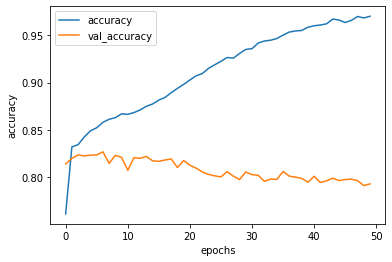

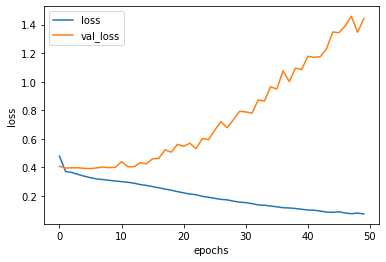

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [12]:
model.save('sarcasm_LSTM.h5')